# ARIMA सह टाइम सिरीज अंदाज

या नोटबुकमध्ये, आम्ही कसे करायचे ते दाखवतो:
- ARIMA टाइम सिरीज अंदाज मॉडेलसाठी टाइम सिरीज डेटा तयार करणे
- टाइम सिरीजमध्ये पुढील HORIZON पायऱ्यांचे (वेळ *t+1* ते *t+HORIZON*) अंदाज करण्यासाठी एक साधे ARIMA मॉडेल अंमलात आणणे
- मॉडेलचे मूल्यमापन करणे

या उदाहरणातील डेटा GEFCom2014 अंदाज स्पर्धेतून घेतला आहे. यात 2012 ते 2014 दरम्यान 3 वर्षांचे तासागणिक वीज लोड आणि तापमान मूल्ये समाविष्ट आहेत. कार्य म्हणजे वीज लोडच्या भविष्यातील मूल्यांचा अंदाज लावणे. या उदाहरणात, आम्ही केवळ ऐतिहासिक लोड डेटाचा वापर करून एका वेळेच्या टप्प्याचा अंदाज कसा लावायचा ते दाखवतो.

ताओ हाँग, पियरे पिन्सन, शू फॅन, हामिदरेझा झारेइपूर, अल्बर्टो ट्रोक्कोली आणि रॉब जे. हायंडमन, "प्रोबॅबिलिस्टिक एनर्जी फोरकास्टिंग: ग्लोबल एनर्जी फोरकास्टिंग कॉम्पिटिशन 2014 आणि त्यापुढे", इंटरनॅशनल जर्नल ऑफ फोरकास्टिंग, खंड 32, क्रमांक 3, पृष्ठे 896-913, जुलै-सप्टेंबर, 2016.


## आवश्यक गोष्टी स्थापित करा
समाधानासाठी आवश्यक असलेल्या काही गोष्टी स्थापित करून सुरुवात करा. या लायब्ररी आणि त्यांचे संबंधित आवृत्ती समाधानासाठी कार्यक्षम असल्याचे ज्ञात आहे:

* `statsmodels == 0.12.2`
* `matplotlib == 3.4.2`
* `scikit-learn == 0.24.2`


In [16]:
!pip install statsmodels

/bin/sh: pip: command not found


In [17]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [18]:
energy = load_data('./data')[['load']]
energy.head(10)

load
2012-01-01 00:00:00 2,698.00
2012-01-01 01:00:00 2,558.00
2012-01-01 02:00:00 2,444.00
2012-01-01 03:00:00 2,402.00
2012-01-01 04:00:00 2,403.00
2012-01-01 05:00:00 2,453.00
2012-01-01 06:00:00 2,560.00
2012-01-01 07:00:00 2,719.00
2012-01-01 08:00:00 2,916.00
2012-01-01 09:00:00 3,105.00

सर्व उपलब्ध लोड डेटा (जानेवारी २०१२ ते डिसेंबर २०१४) प्लॉट करा


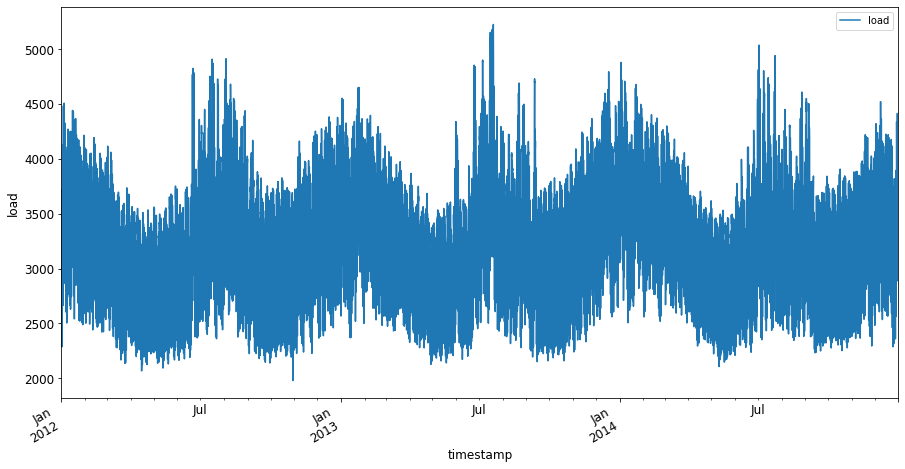

In [19]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## प्रशिक्षण आणि चाचणी डेटा संच तयार करा

### डेटा विभाजनाचे महत्त्व
डेटा विभाजन म्हणजे तुमच्या डेटासेटला दोन भागांमध्ये विभागणे: प्रशिक्षण संच आणि चाचणी संच. हे मशीन लर्निंग मॉडेलच्या अचूकतेचे मूल्यांकन करण्यासाठी महत्त्वाचे आहे.

[!NOTE] चाचणी संच कधीही प्रशिक्षणासाठी वापरू नये. 

### प्रशिक्षण संच
प्रशिक्षण संच मॉडेलला शिकवण्यासाठी वापरला जातो. यामध्ये डेटाचे मोठे प्रमाण असावे जेणेकरून मॉडेल विविध नमुन्यांवरून शिकू शकेल.

### चाचणी संच
चाचणी संच मॉडेलची कार्यक्षमता तपासण्यासाठी वापरला जातो. यामध्ये डेटाचे वेगळे आणि न पाहिलेले नमुने असावेत.

[!TIP] चाचणी संच तयार करताना, सुनिश्चित करा की ते प्रशिक्षण संचापासून वेगळे आहे.

### डेटा विभाजन कसे करावे
डेटा विभाजनासाठी तुम्ही खालील पद्धती वापरू शकता:
1. **मनाने विभाजन**: डेटाचे विशिष्ट प्रमाण प्रशिक्षण आणि चाचणीसाठी मॅन्युअली निवडा.
2. **सॉफ्टवेअर टूल्स**: @@INLINE_CODE_1@@ सारखी टूल्स वापरा जी डेटा स्वयंचलितपणे विभाजित करतात.

### सामान्य प्रमाण
डेटा विभाजनासाठी सामान्य प्रमाण खालीलप्रमाणे आहे:
- 80% प्रशिक्षणासाठी
- 20% चाचणीसाठी

[!WARNING] चुकीचे विभाजन मॉडेलच्या अचूकतेवर परिणाम करू शकते.

### कोड उदाहरण
खाली दिलेला कोड @@CODE_BLOCK_1@@ वापरून डेटा विभाजन कसे करावे हे दाखवतो.

### निष्कर्ष
डेटा विभाजन हा मशीन लर्निंग प्रक्रियेतील महत्त्वाचा टप्पा आहे. योग्य विभाजन केल्याने तुमचे मॉडेल अधिक अचूक आणि विश्वासार्ह होईल.


In [20]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'    

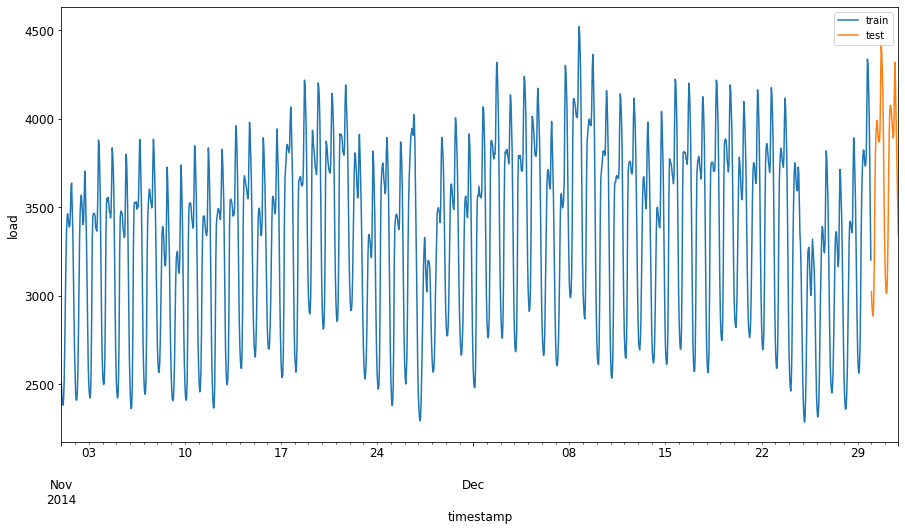

In [21]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [22]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [23]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

load
2014-11-01 00:00:00  0.10
2014-11-01 01:00:00  0.07
2014-11-01 02:00:00  0.05
2014-11-01 03:00:00  0.04
2014-11-01 04:00:00  0.06
2014-11-01 05:00:00  0.10
2014-11-01 06:00:00  0.19
2014-11-01 07:00:00  0.31
2014-11-01 08:00:00  0.40
2014-11-01 09:00:00  0.48

मूळ डेटा वि. स्केल केलेला डेटा:


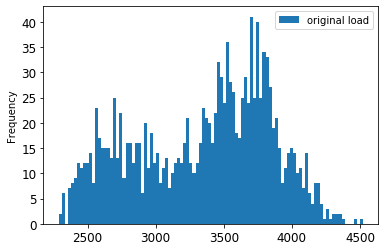

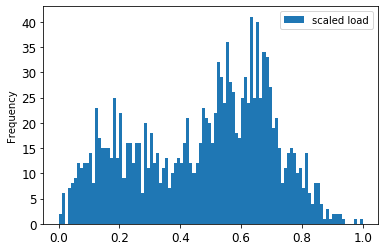

In [24]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

चला चाचणी डेटा देखील स्केल करूया


In [25]:
test['load'] = scaler.transform(test)
test.head()

load
2014-12-30 00:00:00  0.33
2014-12-30 01:00:00  0.29
2014-12-30 02:00:00  0.27
2014-12-30 03:00:00  0.27
2014-12-30 04:00:00  0.30

In [26]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [27]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.239
Date:                            Thu, 30 Sep 2021   AIC                          -6942.477
Time:                                    14:36:28   BIC                          -6911.050
Sample:                                11-01-2014   HQIC                         -6930.725
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8403      0.016     52.226      0.000       0.809       0.872
ar.L2         -0.5220      0.034   

प्रत्येक HORIZON चरणासाठी एक चाचणी डेटा बिंदू तयार करा.


In [28]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

load  load+1  load+2
2014-12-30 00:00:00  0.33    0.29    0.27
2014-12-30 01:00:00  0.29    0.27    0.27
2014-12-30 02:00:00  0.27    0.27    0.30
2014-12-30 03:00:00  0.27    0.30    0.41
2014-12-30 04:00:00  0.30    0.41    0.57

In [29]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

अंदाजांशी वास्तविक भाराची तुलना करा


In [30]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h  prediction   actual
0 2014-12-30 00:00:00  t+1    3,008.74 3,023.00
1 2014-12-30 01:00:00  t+1    2,955.53 2,935.00
2 2014-12-30 02:00:00  t+1    2,900.17 2,899.00
3 2014-12-30 03:00:00  t+1    2,917.69 2,886.00
4 2014-12-30 04:00:00  t+1    2,946.99 2,963.00

सर्व अंदाजांवर **मीन ऍब्सोल्यूट परसेंटेज एरर (MAPE)** गणना करा

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}|\frac{actual_t - predicted_t}{actual_t}|$$


In [31]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [32]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.5570581332313952 %


In [33]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  1.1460048657704118 %


चाचणी संचाच्या पहिल्या आठवड्यासाठी अंदाज विरुद्ध प्रत्यक्ष परिणामांचे आलेख तयार करा


No handles with labels found to put in legend.


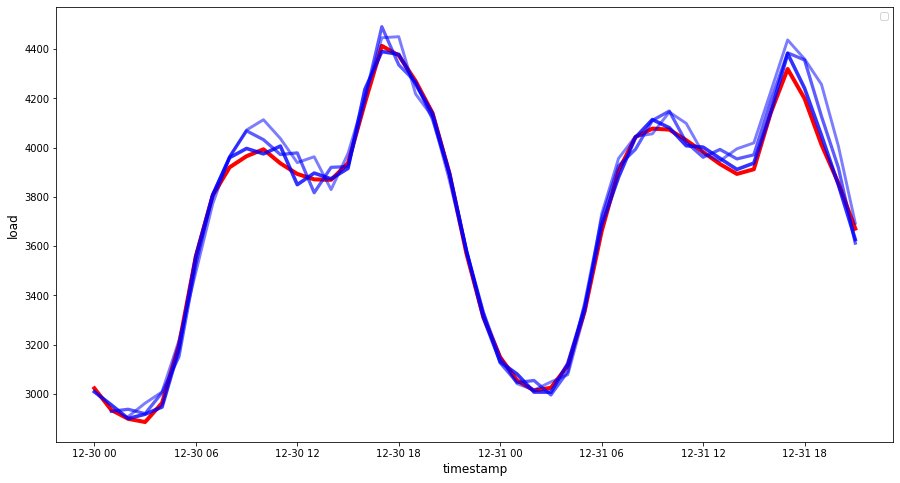

In [34]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()


---

**अस्वीकरण**:  
हा दस्तऐवज AI भाषांतर सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) वापरून भाषांतरित करण्यात आला आहे. आम्ही अचूकतेसाठी प्रयत्नशील असलो तरी कृपया लक्षात ठेवा की स्वयंचलित भाषांतरांमध्ये त्रुटी किंवा अचूकतेचा अभाव असू शकतो. मूळ भाषेतील दस्तऐवज हा अधिकृत स्रोत मानला जावा. महत्त्वाच्या माहितीसाठी व्यावसायिक मानवी भाषांतराची शिफारस केली जाते. या भाषांतराचा वापर करून निर्माण होणाऱ्या कोणत्याही गैरसमज किंवा चुकीच्या अर्थासाठी आम्ही जबाबदार राहणार नाही.
